In [116]:
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("am")
state_utils.set_midas_db_type("standard")
#state_utils.set_cohort("Roodgar")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import gamma
from numba import jit
from numba.typed import List
import config
import slm_utils
from scipy import stats
from scipy.stats import chisquare

import matplotlib

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.rcParams["xtick.major.size"] = 4
plt.rcParams["xtick.major.width"] = 1

plt.rcParams["xtick.minor.size"] = 6
plt.rcParams["xtick.minor.width"] = 2

plt.rcParams["ytick.major.size"] = 6


plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Sans-serif"
})

import matplotlib.patches as mpatches


We simulate the SLM using the Euler-Maruyama technique. That is, we iterate the following equation: 

$$x(t+1) = x(t) + \frac{x(t)}{\tau}\left(1 - \frac{x(t)}{K}\right)\delta_t + \sqrt{\frac{\sigma}{\tau}}x(t)\xi(t)\sqrt{\delta_t},$$ 

where $\xi(t)$ is a draw from a standard normal distribution. $\sigma$ and $K$ are determined directly from the data. Specifically, if $\bar{x}$ is the mean abundance, and $\text{std}(x)$ is its standard deviation, then 

$$\sigma = \frac{2}{\left(\frac{\bar{x}}{\text{std}(x)}\right)^2+1}$$

$$K = \frac{\bar{x}}{1 - \frac{\sigma}{2}} $$

To perform cross-fold validation and test the **predictive** capabilities of the SLM, we determine $\bar{x}$ and $\text{std}(x)$ from the first quarter of the data, and then test the SLM on the entire trajectory. 

But how do we determine the fit of the SLM?

The high level idea here is to see whether the series of transitions between subsequent timepoints, considered as a whole, agrees with what we would expect under the SLM. To determine this, we're going to:
* simulate the SLM between each pair of subsequent time points (i.e. start simulations at time $t=0$, simulate until $t=1$)
* determine the distribution of simulated final values (i.e. at $t=1$)
* bin these values into quintiles
* determine which quintile the observed value (i.e. at $t=1$) falls into
* repeat for every pair of timepoints ($1 \rightarrow 2, 2 \rightarrow 3$, etc.)

Under the null hypothesis that the SLM holds, the distribution of these quintile bins across all timepoints should be uniform. The reason for this is that, definitionally, quintiles are regions of equal probability - at each timepoint, there should be an equal chance that the data lies in each quintile (specifically 1/(number of quintiles)).

Let's see how this works in practice, starting at the species level. 

In [ ]:
def E_t(K,x0,t,tau):
    return K/(1+((K-x0)/x0)*np.exp(-t/tau))

In [5]:
data_dir = config.data_directory
dates = config.dates

#spec_df = pd.read_csv("%sspecies/relative_abundance.txt.bz2" % data_dir,index_col=0,sep="\t")


Here's the abundance trajectory for *B. fragilis* in host *am* from Poyet:

In [ ]:
species = "Bacteroides_ovatus_58035_B"
obs_data = spec_df.loc[species]
params = slm_utils.fit_SLM_params(obs_data,n=train_num)
params

In [98]:
spec_df

timepoint,0,1,2,5,6,7,9,10,12,13,...,524,525,526,531,532,533,534,537,538,539
Phascolarctobacterium_sp_59817_A,NaN,NaN,NaN,NaN,NaN,0.010803,NaN,0.023785,NaN,0.015467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017244
Barnesiella_intestinihominis_62208_A,NaN,NaN,NaN,NaN,NaN,0.013125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016053,NaN
Ruminococcus_bicirculans_59300_A,NaN,0.025341,0.059925,NaN,NaN,0.016109,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bacteroides_uniformis_57318_A,0.097250,0.106400,0.092371,0.179700,0.140319,0.144183,0.128073,0.116682,0.141561,0.069706,...,0.162765,0.216812,0.238023,0.069904,0.184115,0.187216,0.143129,0.182858,0.149643,0.185502
Ruminococcus_bromii_62047_A,NaN,0.021448,NaN,NaN,NaN,NaN,NaN,0.158282,0.044124,0.073153,...,NaN,NaN,NaN,NaN,0.034901,0.030704,0.035059,NaN,NaN,0.022633
Faecalibacterium_prausnitzii_57453_A,NaN,0.020836,NaN,NaN,NaN,0.011354,NaN,NaN,NaN,0.017594,...,NaN,NaN,NaN,NaN,0.017046,0.024570,NaN,NaN,NaN,NaN
Parabacteroides_merdae_56972_A,NaN,NaN,NaN,NaN,0.079141,0.087541,0.238293,0.097206,0.046594,0.061427,...,NaN,0.041102,0.036063,NaN,0.021560,NaN,NaN,0.060152,0.056929,0.036106
Bacteroides_stercoris_56735_A,NaN,0.015619,NaN,NaN,0.030357,0.039915,0.025947,0.024356,0.038729,0.051250,...,NaN,NaN,NaN,NaN,0.025400,NaN,0.024139,0.035670,0.031252,0.025288
Eubacterium_rectale_56927_A,0.017037,0.005719,NaN,NaN,NaN,0.007644,NaN,0.005587,0.014266,0.018588,...,NaN,NaN,NaN,0.037593,0.016587,0.015229,0.030234,0.005451,0.014809,0.008561
Eubacterium_rectale_56927_B,0.170371,0.037176,NaN,NaN,NaN,0.059624,NaN,0.039109,0.110561,0.137550,...,NaN,NaN,NaN,0.247040,0.120255,0.091373,0.195148,0.024529,0.114771,0.073623


In [105]:

#spec_df.columns = dates[spec_df.columns]
#spec_df = spec_df.reindex(sorted(spec_df.columns), axis=1)
spec_df = pd.read_csv("strains_%s.csv" % config.host,index_col=0)
spec_df.columns = dates[spec_df.columns]

train_num = len(dates)//3

species = "Bacteroides_vulgatus_57955_B"
obs_data = spec_df.loc[species]
obs_data = obs_data[obs_data.notna()]
params = slm_utils.fit_SLM_params(obs_data,n=train_num)

S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/1000)

T = spec_df.columns[-1]
num_iters = int(T/(1.0*S.delta_t))
num_reps = 1
S.run_sim(num_iters,num_reps,record_steps=True)

X = np.stack(S.trajectory,axis=0)

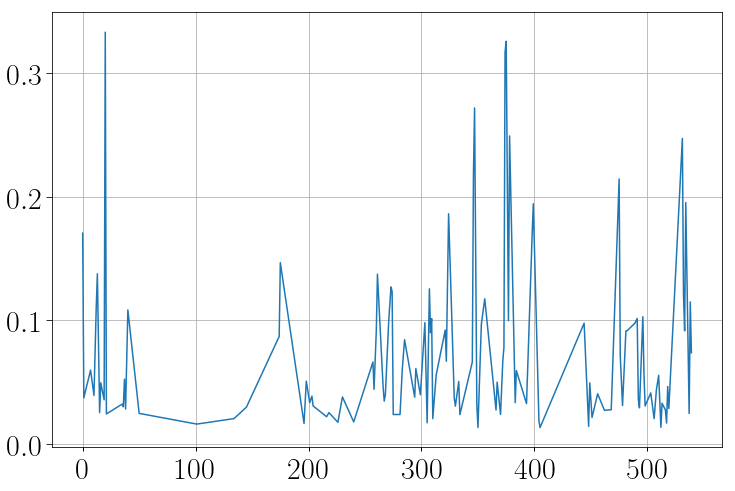

In [100]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(obs_data.index,obs_data);

ax.grid(True)

#x = np.linspace(0,T,num_iters+1)

#ax.plot(x,X,alpha=.5);

We use the first third of data points (in green) to determine our SLM parameters $\sigma$ and $K$:

In [106]:
train_num_ind = len(spec_df.loc[species].index)//3

In [107]:
(S.afd.ppf(.05),S.afd.ppf(.95))

(0.16853659883235328, 0.37601265849492527)

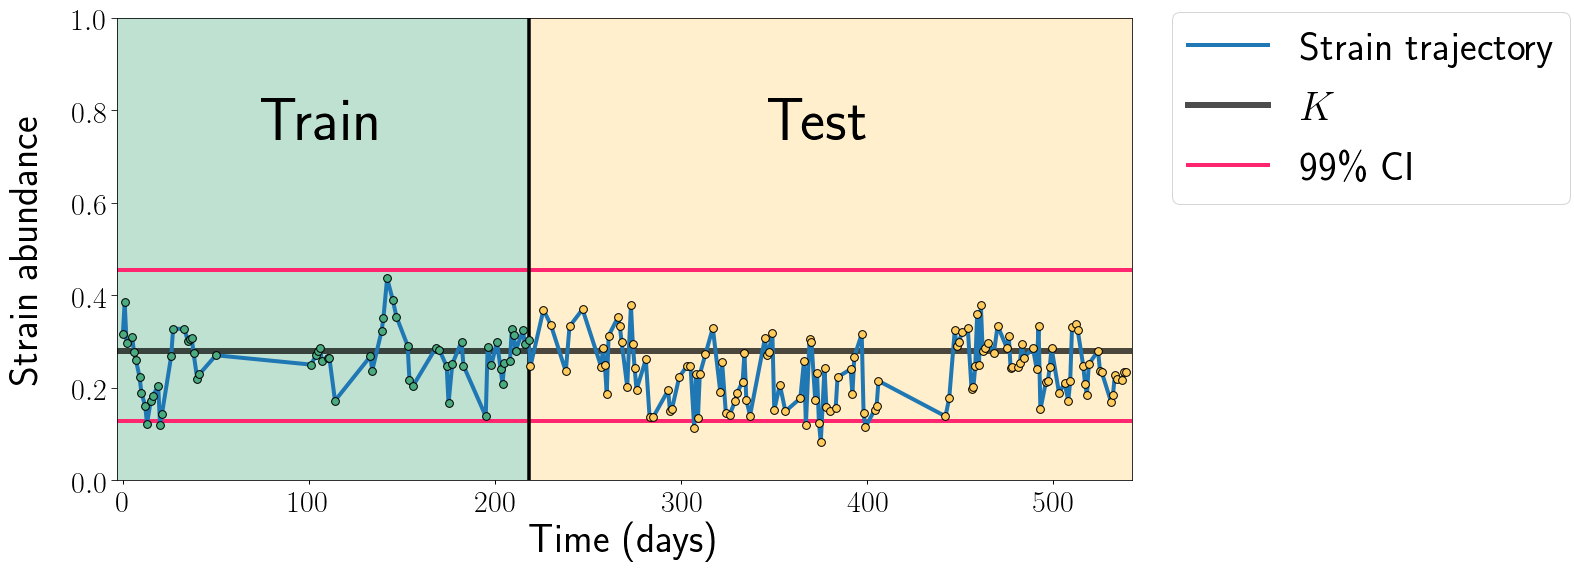

In [138]:
train_num_day = np.percentile(spec_df.loc[species].index.values,33)
fig,ax = plt.subplots(figsize=(16,8))
spec_df.loc[species].plot(ax=ax,lw=4,zorder=10,label="Strain trajectory")
ax.scatter(list(spec_df.loc[species].index)[:train_num_ind],spec_df.loc[species].values[:train_num_ind],s=60,zorder=20,color="#4aab80",edgecolor="k")
ax.scatter(list(spec_df.loc[species].index)[train_num_ind:],spec_df.loc[species].values[train_num_ind:],s=60,zorder=20,color="#ffcc5c",edgecolor="k")

ax.axhline(S.K,lw=6,color="k",label=r"$K$",alpha=.7)

ax.axhline(S.afd.ppf(.005),lw=4,color="#ff256f",label="99\% CI")
ax.axhline(S.afd.ppf(.995),lw=4,color="#ff256f")

ax.axvline(train_num_day,color="k",lw=3.5)
ax.axvspan(-3,train_num_day,color="#4aab80",alpha=.35)
ax.axvspan(train_num_day,spec_df.columns.max()+3,color="#ffcc5c",alpha=.3)
#ax.semilogy()
ax.set_ylim([0,1])
ax.set_xlim([-3,max(spec_df.loc[species].index) + 3])
ax.set_xlabel("Time (days)",size=40,fontweight="bold")
ax.set_ylabel("Strain abundance",size=40,labelpad=25)
fig.text(.23,.75,"Train",size=60)
fig.text(.67,.75,"Test",size=60)


fig.legend(prop={'size': 40},loc="upper left",bbox_to_anchor=(1,1));                  

fig.tight_layout()
#ax.grid(True)

In [ ]:
S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1/100)
dates_diff = dates.diff()

Now that we've calculated $\sigma$ and $K$, let's see how the quintile binning scheme works, starting at timepoint 0. 

Here are the observed abundances at timepoint 0 and 1:

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(dates[:2].values,obs_data[:2],s=100,color="green")
ax.plot(dates[:2].values,obs_data[:2],ls="--",color="green")
#ax.set_ylim([0.005,0.015])
ax.set_xlabel("Time",size=20)

Now, starting at timepoint 0, we simulate the SLM until timepoint 1 a total of 10,000 times.

Let's see what these final values (in blue) look like:

In [ ]:
i = 0
T = dates_diff[i+1]
num_iters = int(T/(S.delta_t))

init_val = obs_data.iloc[i]
num_reps = 10000
S.set_init_val(obs_data.iloc[i])
S.run_sim(num_iters,num_reps,record_steps=False)

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(dates[:2].values,obs_data[:2],s=100,color="green")
ax.plot(dates[:2].values,obs_data[:2],ls="--",color="green",zorder=10)
ax.scatter(dates[1]*np.ones(num_reps),S.x_i,color="blue",alpha=.002)
#ax.set_ylim([0.005,0.015])
ax.set_xlabel("Time",size=20)

Let's try plotting the true and simulated final values as a histogram:

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3,label="SLM simulations");
ax.axvline(obs_data.iloc[i+1],color="green",lw=4,label="Observed");
ax.axvline(E_t(S.K,init_val,T,S.tau),color="k",ls="--",lw=4,zorder=5,label="Expected")
ax.legend()

Now, we're going to divide the simulated distribution into 38 quintiles. In general, it's better to have more quintiles, but the number of quintiles we can use is going to depend on the length of the time series. Longer time series allow us to still perform meaningful statistical tests with a larger number of quintiles (the rule I've seen recommended is # of observations/# quintiles > 5)

In [ ]:
quins = np.quantile(S.x_i,np.linspace(0,1,quin_bins))

quin_bins

In [ ]:
np.digitize(100,np.quantile(S.x_i,np.linspace(0,1,quin_bins)))

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3);

quin_bins = len(obs_data)//4

quins = np.quantile(S.x_i,np.linspace(0,1,quin_bins))

ax.axvline(quins[0],lw=.25,color="k",label="Quintiles")
for q in quins:
    ax.axvline(q,lw=.25,color="k")

binn = np.digitize(obs_data.iloc[i+1],np.quantile(S.x_i,np.linspace(0,1,quin_bins)))
ax.axvline(obs_data.iloc[i+1],color="green",lw=1,label="Observed");

#ax.axvspan(quins[binn],quins[binn+1],color="green",zorder=1,label="Observed")

ax.legend();

The observed data point at time 1 falls into one of these quintiles, shown in green:

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3);

quin_bins = len(obs_data)//4

quins = np.quantile(S.x_i,np.linspace(0,1,quin_bins))

ax.axvline(quins[0],lw=.25,color="k",label="Quintiles")
for q in quins:
    ax.axvline(q,lw=.25,color="k")

binn = np.digitize(obs_data.iloc[i+1],np.quantile(S.x_i,np.linspace(0,1,quin_bins)))

ax.axvspan(quins[binn-1],quins[binn],color="green",zorder=1,label="Observed quintile")

ax.legend();

Now, let's try the next pair of timepoints:

In [ ]:
i = 1
T = dates_diff[i+1]
num_iters = int(T/(S.delta_t))

init_val = obs_data.iloc[i]
num_reps = 100000
S.set_init_val(obs_data.iloc[i])
S.run_sim(num_iters,num_reps,record_steps=False)

xx=[E_t(S.K,init_val,t,S.tau) for t in np.linspace(0,T,num_iters)]

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3,label="SLM simulations");
ax.axvline(obs_data.iloc[i+1],color="green",lw=4,label="Observed");
ax.legend()

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3);

quins = np.quantile(S.x_i,np.linspace(0,1,quin_bins))

ax.axvline(quins[0],lw=.25,color="k",label="Quintiles")
for q in quins:
    ax.axvline(q,lw=.25,color="k")

binn = np.digitize(obs_data.iloc[i+1],np.quantile(S.x_i,np.linspace(0,1,quin_bins)))

ax.legend();

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(S.x_i,bins=50,alpha=.3);

quins = np.quantile(S.x_i,np.linspace(0,1,quin_bins))

ax.axvline(quins[0],lw=.25,color="k",label="Quintiles")
for q in quins:
    ax.axvline(q,lw=.25,color="k")

binn = np.digitize(obs_data.iloc[i+1],np.quantile(S.x_i,np.linspace(0,1,quin_bins)))

ax.axvspan(quins[binn-1],quins[binn],color="green",zorder=1,label="Observed quintile",alpha=.2)
ax.axvline(obs_data.iloc[i+1],color="green",lw=4,label="Observed");

ax.legend();

Now, we simply repeate this procedure for every pair of timepoints. Under the null hypothesis, we should see a roughly equal number of points in each bin. Again, this is because the quintiles are equally probable outcomes at each successive timepoint.

In [ ]:
import time

In [ ]:
Y = []
t1 = time.time()
quin_bins = len(obs_data)//4
bin_list = []
for i in range(len(obs_data) - 1):
    T = dates_diff[i+1]
    num_iters = int(T/(S.delta_t))

    init_val = obs_data.iloc[i]
    num_reps = 1000
    S.set_init_val(obs_data.iloc[i])
    S.run_sim(num_iters,num_reps,record_steps=False)
    Y.append(S.x_i)
    #bin_list.append(np.digitize(obs_data.iloc[i+1],np.percentile(S.x_i,np.linspace(0,100,quin_bins))))
    
    
#     if i % 10 == 0:
#         print(1.0*i/(len(obs_data) - 1))
#         t2 = time.time()
#         print(t2 - t1)
        
t2 = time.time()
     
print(t2 - t1)

In [ ]:
i = 3
plt.hist(Y[i]);
plt.axvline(obs_data.iloc[i+1],zorder=10,color="red");


In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot([y[:100] for y in Y],color="blue",alpha=.2);
ax.plot(obs_data.values[1:],color="red",lw=3)
ax.semilogy();

In [ ]:
x=[]
for i in range(len(Y)):
    x.append(stats.percentileofscore(Y[i], obs_data.iloc[i+1]))

chisquare(np.histogram(x,bins=len(x)//6)[0])[1]

In [ ]:
plt.hist(x,bins=len(x)//5)

In [ ]:
chisquare(np.histogram(x,bins=25)[0],ddof = 1)

In [ ]:
x=[]
for i in range(len(Y)):
    x.append(stats.percentileofscore(Y[i], obs_data.iloc[i+1])/100)


In [ ]:
np.histogram(x,bins=40)

In [ ]:
plt.hist(stats.uniform.rvs(size=192))
plt.hist(x,alpha=.3);

In [ ]:
H=np.histogram(x,bins=35)
plt.scatter(H[1][1:],H[0])

In [ ]:
x

In [ ]:
stats.kstest(x,cdf='uniform')

In [ ]:
plt.hist(S.x_i,bins=25)
plt.axvline(obs_data.iloc[i+1],zorder=10,color="red");
for x in np.percentile(S.x_i,np.linspace(0,100,quin_bins)):
    plt.axvline(x,color="k")

In [ ]:
obs_data.iloc[i+1]

I've chosen the number of bins (38) so that we should expect to see 5 timepoint pairs fall in each quintile under the null hypothesis. Here is the true distribution:

In [ ]:
Y = np.unique(bin_list,return_counts=True)
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(Y[0],Y[1],zorder=10,s=50)
#ax.set_ylim([0,15])
ax.set_ylabel("Count",size=20)
ax.set_xlabel("Quintile",size=20)
ax.axhline(5,color="k",ls="--",zorder=1)

And now, we can determine whether the observed quintile distribution matches what we expect (i.e. equal chance in each bin) using a $\chi^2$ test. The p-value from this test is:

In [ ]:
chisquare(np.histogram(x,bins=30)[0])[1]

In [ ]:
np.histogram(x,bins=5)

So, we accept the null hypothesis that the SLM generated the data!

In [ ]:
from scipy import stats


In [ ]:
np.unique(bin_list,return_counts=True)[1]

In [ ]:
np.unique(bin_list,return_counts=True)[0]/62

In [ ]:
stats.kstest(np.unique(bin_list,return_counts=True)[1],cdf='uniform')

In [ ]:
np.unique(bin_list,return_counts=True)[0]

In [ ]:
plt.hist(np.unique(bin_list,return_counts=True)[1]/10)

In [ ]:
np.digitize(.15,np.quantile(S.x_i,np.linspace(0,1,quin_bins)))

In [ ]:
from parse_midas_data import parse_good_species_list


In [ ]:
good_species = parse_good_species_list()


In [ ]:
strain_df = pd.read_csv("strains_%s.csv" % config.host,index_col=0)
species_list = list(set([s[:-2] for s in strain_df.index]))
spec_df = pd.read_csv("%sspecies/relative_abundance.txt.bz2" % data_dir,index_col=0,sep="\t")

In [ ]:
data_dir = config.data_directory
dates = config.dates

ddd = {}
num_reps = 1000
for strain in strain_df.index:
    obs_data = strain_df.loc[strain]
    obs_data = obs_data[obs_data.notna()]
    train_num = int(len(obs_data)/2.0) - 1
    params = slm_utils.fit_SLM_params(obs_data,n=train_num)

    S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/100)

    dates = config.dates
    dates = dates.loc[obs_data.index]
    dates_diff = dates.diff()
    
    Y = []
    bin_list = []
    for i in range(len(obs_data) - 1):
        
        T = dates_diff.iloc[i+1]
        num_iters = int(T/(S.delta_t))

        init_val = obs_data.iloc[i]
        
        S.set_init_val(init_val)
        S.run_sim(num_iters,num_reps,record_steps=False)
        Y.append(S.x_i)

    x=[]
    for i in range(len(Y)):
        x.append(stats.percentileofscore(Y[i], obs_data.iloc[i+1]))

    print((strain,int(len(x)/5.0)))
    print(chisquare(np.histogram(x,bins=int(len(x)/5.0))[0])[1])
    ddd[strain] = chisquare(np.histogram(x,bins=int(len(x)/5.0))[0])[1]

In [ ]:
(pd.Series(ddd) > .05).mean()

In [ ]:
plt.plot(strain_df.loc["Faecalibacterium_prausnitzii_61481_A"].values)
plt.plot(strain_df.loc["Faecalibacterium_prausnitzii_61481_B"].values)

In [ ]:
pd.Series(ddd).to_csv("~/strain_stability_revisions/strainstability/analysis/chisq/Poyet/%s_strain_chisq_test_cross.txt" % (config.host))

In [ ]:
sss = {}

for species in good_species:
    obs_data = spec_df.loc[species]
    obs_data_strain = strain_df.loc["%s_A" % species]
    obs_data = obs_data[obs_data_strain.notna()]
    
    train_num = int(2*len(obs_data)/3.0)
    params = slm_utils.fit_SLM_params(obs_data,n=train_num)

    S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/100)

    Y = []
    bin_list = []
    
    ### return date differences
    dates = config.dates
    dates = dates.loc[obs_data.index]
    dates_diff = dates.diff()

    ### run simulations
    for i in range(len(obs_data) - 1):
        
        T = dates_diff.iloc[i+1]
        num_iters = int(T/(S.delta_t))

        init_val = obs_data.iloc[i]
        S.set_init_val(obs_data.iloc[i])
        S.run_sim(num_iters,num_reps,record_steps=False)
        Y.append(S.x_i)

    ### now calculate the percentile of the data w/r/t to the simulations
    x=[]
    for i in range(len(Y)):
        x.append(stats.percentileofscore(Y[i], obs_data.iloc[i+1]))

    print(species)
    print(chisquare(np.histogram(x,bins=int(len(x)/7.0))[0])[1])
    sss[species] = chisquare(np.histogram(x,bins=int(len(x)/7.0))[0])[1]

In [ ]:
sss

In [ ]:
pd.Series(sss).to_csv("~/strain_stability_revisions/strainstability/analysis/chisq/Poyet/%s_strain_chisq_test_cross.txt" % (config.host))